# Imports

In [ ]:
# Regular imports
import os
import numpy as np
import pandas as pd
# Scipy imports
from scipy.stats import linregress
from scipy.optimize import curve_fit
# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
# Image processing imports
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
import cv2
import csv
from skimage import measure, exposure
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops, regionprops_table
from skimage.draw import ellipse_perimeter, line, rectangle

# Directories and Experimental Parameters

In [ ]:
# INSERT PATH TO COALESCENCE EVENTS IMAGE DIRECTORY HERE
COALESCENCE_EVENTS_DIR = ""
os.chdir(COALESCENCE_EVENTS_DIR)

# INSERT PATH TO SAVE IMAGES IN
RESULTS_DIR = ""

In [ ]:
# Create array of timepoints names `timepoints`
timepoints = np.linspace(0, 780, 27)
# timepoints = np.linspace(0, 180, 13)

# print(timepoints)

# Helper functions

In [ ]:
def get_initial_avg_size(
    image,
    pixel_to_micron_conversion = 14.1183
):
    """
    :par image: single image of sintering/fusing droplets,
    :par pixel_to_micron_conversion:
        default is the one for DiMicheleLab 20x lens (from ND2 metadata) -- CHANGE TO MATCH YOUR SETUP!

    :returns: average size as characteristic length.

    Uses unsupervised Otsu thresholding (skimage.filters.threshold_otsu)
    """
    # compute threshold
    thresh = threshold_otsu(image)
    # binarise
    binary = image > thresh

    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image)
    f.add_subplot(1,2, 2)
    plt.imshow(binary)
    plt.show(block=True)

    # get object labels - there are at least two, i.e. the ones that are going to fuse + background
    labels = measure.label(binary)

    # Find the two labels that correspond to our two objects
    # Most frequent label = background
    # Get second most common label = 1st droplet
    freq = np.bincount(labels.reshape(-1))
    target_label_idx1 = np.argmax(freq == np.sort(freq)[-2])
    target_label1 = np.array(
        [i if i == target_label_idx1 else 0
         for i in list(labels.reshape(-1))],
        dtype = np.uint8
    ).reshape(image.shape[0], image.shape[1])

    # Get third most common label = 2nd droplet
    # if len(np.unique(freq)) >= 3:
    # # Get the index of the third most common label (2nd droplet)
    #     target_label_idx2 = np.argmax(freq == np.sort(freq)[-3])
    # else:
    # # Handle the case when there are fewer than 3 unique values
    # # For example, set target_label_idx2 to 0 or handle the error condition
    #     target_label_idx2 = np.zeros_like(target_label_idx1)

    target_label_idx2 = np.argmax(freq == np.sort(freq)[-3])
    target_label2 = np.array(
        [i if i == target_label_idx2 else 0
         for i in list(labels.reshape(-1))],
        dtype = np.uint8
    ).reshape(image.shape[0], image.shape[1])

    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(target_label1)
    f.add_subplot(1,2, 2)
    plt.imshow(target_label2)
    plt.show(block=True)

    # Compute properties (props) using skimage.measure.regionprops_table
    props = [regionprops_table(label,
                               properties=('centroid',
                                           'orientation',
                                           'axis_major_length',
                                           'axis_minor_length'))
             for label in [target_label1, target_label2]
            ]
    # Get sizes as average of the two major axes
    sizes = np.array(
        [
            (props[i]['axis_major_length'][0] + props[i]['axis_minor_length'][0])/2
            for i in [0, 1]
        ]
    )

    # Compute and return mean of those sizes as characteristic length of sintering droplets (l_c)
    l_c = np.mean(sizes/pixel_to_micron_conversion)
    return l_c

In [ ]:
def get_region_labels(event):
    """
    Get label of sintering droplet complex given a fusion event.
    :par event: fusion event (timelapse, i.e. sequence of images)

    :returns target_labels:
    """
    # Get shape of each image (all identical in an event)
    image_shape = event[0].shape
    # measure thresholded image (image > threshold)
    labels_list = [
        measure.label(image > threshold_otsu(image))
        for image in event
    ]
    # get target labels only
    freqs = [np.bincount(label.reshape(-1)) for label in labels_list]
    # find second most frequent index = larger and most important label after background label
    # after first fusion contact, there is only ONE object of interest
    target_label_idxs = [np.argmax(freq == np.sort(freq)[-2]) for freq in freqs]
    # get most frequent label == target
    target_labels = []
    for label, idx in zip(labels_list, target_label_idxs):
        target_labels.append(np.array(
            [i if i == idx else 0
             for i in list(label.reshape(-1))],
            dtype = np.uint8
        ).reshape(image_shape[0], image_shape[1]))
    return target_labels

In [ ]:
def enhance_contrast(
    img,
    perc = 0.2
):
    """
    Enhances contrast via skimage.exposure using contrast-stretching method

    :par img: image
    :par perc: percentage of pixels to saturate in contrast-strethed image
        - default: 0.2%

    :returns img_rescale (contrast-enhanced image)
    """
    p_low, p_high = np.percentile(img, (perc, 100-perc))
    img_rescale = exposure.rescale_intensity(img, in_range=(p_low, p_high))
    return img_rescale

In [ ]:
def draw_ellipses_initial_condition(
    image,
    props,
    channels
):
    """
    Draw the best-fit ellipse for the initial condition ONLY (single image)
    :par image: image to draw best-fit ellipse on
    :par props: properties of the segmented image
    :par channels: channels which are non-zero (e.g. for us: A - red, B - cyan)
    """
    # Contrast-enhance image
    img = enhance_contrast(image)

    # Convert image to RGB where image is either red or blue channel
    channel_images = {}
    for channel in channels.keys():
        if channels[channel] == True:
            channel_images[channel] = np.array(img)
        else:
            # for missing channels, just create blank images (all zeros)
            channel_images[channel] = np.zeros(img.shape[:2], dtype="uint8")

    # Merge channels into RGB image for use with cv2 below
    img_colour = cv2.merge([channel_images['red'],
                           channel_images['green'],
                           channel_images['blue']])

    for droplet, colour in zip([0, 1], [[0, 255, 255], [0, 0, 255]]):
        # Get properties we need
        major_axis_length = props[droplet]['axis_major_length']
        minor_axis_length = props[droplet]['axis_minor_length']
        centroid_row, centroid_col = props[droplet]['centroid-0'], props[droplet]['centroid-1']
        orientation = np.pi/2 - props[droplet]['orientation']

        # Draw ellipse perimeter and set colour
        rr, cc = ellipse_perimeter(int(centroid_row), int(centroid_col),
                                   int(minor_axis_length/2), int(major_axis_length/2),
                                   orientation=orientation, shape=event[index].shape)
        img_colour[rr, cc] = colour

        # Draw major axis line
        rr_major, cc_major = line(int(centroid_row - 0.5 * major_axis_length * np.sin(orientation)),
                                  int(centroid_col - 0.5 * major_axis_length * np.cos(orientation)),
                                  int(centroid_row + 0.5 * major_axis_length * np.sin(orientation)),
                                  int(centroid_col + 0.5 * major_axis_length * np.cos(orientation)))
        img_colour[rr_major, cc_major] = colour

        # Draw minor axis line
        rr_minor, cc_minor = line(int(centroid_row - 0.5 * minor_axis_length * np.cos(orientation)),
                                  int(centroid_col + 0.5 * minor_axis_length * np.sin(orientation)),
                                  int(centroid_row + 0.5 * minor_axis_length * np.cos(orientation)),
                                  int(centroid_col - 0.5 * minor_axis_length * np.sin(orientation)))
        img_colour[rr_minor, cc_minor] = colour
    return img_colour

def draw_ellipse_fit(
    event,
    props,
    channels,
    label,
    number,
    pixel_to_micron_conversion = 14.1183
):
    """
    Parameters:
    :par event: coalescence event timelapse
    :props: properties of segmented regions
    :par channels: channels which are non-zero (e.g. for us: A - red, B - cyan)
    :par label: nametag to save images
    :par number: corresponds to coalescence file number, used with nametag above to save images
    :par pixel_to_micron_conversion: pixel calibration - default value: 20x lens DiMicheleLab
        CHANGE THIS TO MATCH YOUR SETUP

    :returns images: COLLECTION of coalescence event images with best-fit ellipses drawn
    """
    # Initialise results
    images = []

    # Loop through images in coalescence event
    for index in range(len(event)):
        # Get image from event
        img = enhance_contrast(event[index])

        # Convert image to RGB where image is either red or blue channel
        channel_images = {}
        for channel in channels.keys():
            if channels[channel] == True:
                channel_images[channel] = np.array(img)
            else:
                # for missing channels, just create blank images (all zeros)
                channel_images[channel] = np.zeros(img.shape[:2], dtype="uint8")

        # Merge channels into RGB image for use with cv2 below
        img_colour = cv2.merge([channel_images['red'],
                               channel_images['green'],
                               channel_images['blue']])

        # Get properties we need
        major_axis_length = props[index]['axis_major_length']
        minor_axis_length = props[index]['axis_minor_length']
        centroid_row, centroid_col = props[index]['centroid-0'], props[index]['centroid-1']
        orientation = np.pi/2 - props[index]['orientation']

        # Draw ellipse perimeter
        rr, cc = ellipse_perimeter(int(centroid_row), int(centroid_col),
                                   int(minor_axis_length/2), int(major_axis_length/2),
                                   orientation=orientation, shape=event[index].shape)
        img_colour[rr, cc] = [255, 255, 255]

        # Draw major axis line
        rr_major, cc_major = line(int(centroid_row - 0.5 * major_axis_length * np.sin(orientation)),
                                  int(centroid_col - 0.5 * major_axis_length * np.cos(orientation)),
                                  int(centroid_row + 0.5 * major_axis_length * np.sin(orientation)),
                                  int(centroid_col + 0.5 * major_axis_length * np.cos(orientation)))
        img_colour[rr_major, cc_major] = [255, 255, 255]

        # Draw minor axis line
        rr_minor, cc_minor = line(int(centroid_row - 0.5 * minor_axis_length * np.cos(orientation)),
                                  int(centroid_col + 0.5 * minor_axis_length * np.sin(orientation)),
                                  int(centroid_row + 0.5 * minor_axis_length * np.cos(orientation)),
                                  int(centroid_col - 0.5 * minor_axis_length * np.sin(orientation)))
        img_colour[rr_minor, cc_minor] = [255, 255, 255]

        # draw scale bar for first image of the series - 10 um
#         if index == 0:
#             size_um = 15
#             size_px = int(size_um * pixel_to_micron_conversion)
#             thickness_px = 10
#             rr, cc = rectangle(start = [img.shape[0] - 10 - thickness_px, 10],
#                                        end = [img.shape[0] - 10, 10 + size_px])
#             img_colour[rr, cc] = [255, 255, 0] #red+green = yellow

        # Append to growing image list
        images.append(img_colour)
    # Plot entire fusion event
    plt.subplots(1, len(images), figsize = (len(images)*6, 6))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')
    # CHECK THAT YOU HAVE DEFINED RESULTS_DIR TERMINATING WITH `/`
    # Save results
    # plt.savefig(RESULTS_DIR + 'Anneal_40C_' + str(label) + '_' + str(number)+'.svg')
    plt.show()
    return images


def save_to_csv(data, file_path):
    if isinstance(data, list):
        # Convert list to DataFrame
        df = pd.DataFrame(data)
    elif isinstance(data, pd.DataFrame):
        df = data
    else:
        raise ValueError("Unsupported data type. Please provide a list or pandas DataFrame.")

    # Save DataFrame to CSV
    df.to_csv(file_path, index=False)

In [ ]:
# Define exponential decay for fitting
def exponential(t, a, tau):
    """
    Simple exponential decay
    :par t - time
    :par a - amplitude scaling
    :par tau - time decay constant
    """
    return 1+ a*np.exp(-t/tau)

# Analysis

In [ ]:
# Change directory into subdir of choice - here coalescence events for A condensates
# os.chdir( '/content/drive/My Drive/4. Lab/6. Data processing tools/Temp')

# Define files of interest
event_files = [
    'ROI-1.tif',
    'ROI-2.tif',
    'ROI-3.tif',
    'ROI-5.tif',
    'ROI-6.tif',
    'ROI-9.tif',
    'ROI-11.tif'
]
# Here, each file is as long as a pristine timelapse, but only contains the (manually) cropped region
# surrounding the pair of fusing droplets
# However, the fusion event is not that long!
# Manually checked the time ranges of the fusion event in each file -> event_ranges
# These are indices of timepoints, not time values themselves.
# Ranges in `event_ranges` are paired with `event_files`
event_ranges = [
    range(2, 26), # 1
    range(1, 26), # 2
    range(0, 15), # 3
    range(0,11), # 5
    range(2,14), # 6
    range(1,26), # 9
    range(0,11) # 11
]
# Time constants (tau)
taus = []
# Initial sizes (characteristic size l_c)
# initial_sizes = []
# Loop through the fusion event files
for index, event_file in enumerate(event_files):
    # Get characteristic length (l_c) from before the sintering event
    # initial_size = get_initial_avg_size(
    #     cv2.imreadmulti(event_file)[1][event_ranges[index][0]]
    # )
    # initial_sizes.append(initial_size)
    # print("Initial size [um] = ", initial_size)

    # Extract relevant time range from event file
    event = cv2.imreadmulti(event_file)[1][event_ranges[index][0]:event_ranges[index][-1]]
    plt.imshow(event[0])
    # Get segmentation labels
    labels_list = get_region_labels(event)

    # Compute geometrical properties, including major and minor axis lengths
    props = [regionprops_table(label, properties=('centroid',
                                                 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length')) for label in labels_list]
    save_to_csv(props, f"{RESULTS_DIR}/props_{index}.csv")

    # Compute aspect ratio from major and minor axis length
    ARs = []
    for i in range(len(props)):
        AR = props[i]['axis_major_length'][0]/props[i]['axis_minor_length'][0]
        ARs.append(AR)

    max_timepoint = np.max(
        timepoints[event_ranges[index][0]:event_ranges[index][-1]] - timepoints[event_ranges[index][0]]
    )
    # Prepare plot
    plt.figure(figsize = (8, 3))
    # Plot raw datapoints
    plt.plot(
        timepoints[event_ranges[index][0]:event_ranges[index][-1]] - timepoints[event_ranges[index][0]],
        ARs,
        'o',
        color = '#D96459',
        ms = 10,
        label = 'Data'
    )
    # Fit exponential decay
    params, pcov = curve_fit(
        exponential,
        timepoints[event_ranges[index][0]:event_ranges[index][-1]] - timepoints[event_ranges[index][0]],
        np.array(ARs),
        p0 = [ARs[0] - 1, 25]
    )
    # Plot fitted profile
    plt.plot(
        timepoints[event_ranges[index][0]:event_ranges[index][-1]] - timepoints[event_ranges[index][0]],
        exponential(
            timepoints[event_ranges[index][0]:event_ranges[index][-1]] - timepoints[event_ranges[index][0]],
            params[0],
            params[1]
        ),
        color = 'gray',
        ls = '--',
        lw = 2,
        label = 'Fit'
    )
    plt.xlabel('Time [min]', fontsize = 20)
    plt.xticks(
        np.arange(0, max_timepoint+15, 15),
        [str(int(i)) if i%2 == 0 else '' for i in np.arange(0, max_timepoint+15, 15)],
        fontsize = 20
    )
    plt.ylabel('Aspect Ratio [a.u.]', fontsize = 20)
    plt.yticks([1, 1.25, 1.5, 1.75, 2, 2.25], [1, '', 1.5, '', 2, ''], fontsize = 20)
    plt.ylim([0.75, 2.25])
    plt.xlim([-15, 195])
    ax = plt.gca()
    ax.tick_params(direction = 'in', length = 6)
    plt.legend(frameon = False, fontsize = 20)

    # if not index:
        # plt.savefig(RESULTS_DIR + 'Anneal_3swt_50C.svg', dpi = 300)

    # Append computed time constant to list
    taus.append(params[1])

    # Show best-fit ellipses
    images_ellipse = draw_ellipse_fit(
        event,
        props,
        channels = {'red': True, 'green' : False, 'blue' : False},
        label = '3sv2',
        number = index
    )

In [ ]:
print(taus)

[172.10616250171995, 292.86063152435474, 211.03717916115073, 205.3717447514666, 193.13811433897726, 363.5272320664212, 99.10813860516207]


If needed, do the same for other samples (e.g. B condensates in our case)

# Results / Visualisation

In [ ]:
initial_sizes_all = {"1": 3.78875, "2": 3.11675, "3": 3.294, "4": 2.18225, "5": 2.03975,
                     "6": 3.702, "7": 1.8805, "9": 4.35775, "10": 1.4915, "11": 1.79225, "12": 2.07575}

initial_sizes = [
    initial_sizes_all["1"],
    initial_sizes_all["2"],
    initial_sizes_all["3"],
    initial_sizes_all["5"],
    initial_sizes_all["6"],
    initial_sizes_all["9"],
    initial_sizes_all["11"]
    ]

LinregressResult(slope=3468.6413537513836, intercept=2228.904124413557, rvalue=0.6338409812240182, pvalue=0.126373287096749, stderr=1892.926889380855, intercept_stderr=6195.509196180929)


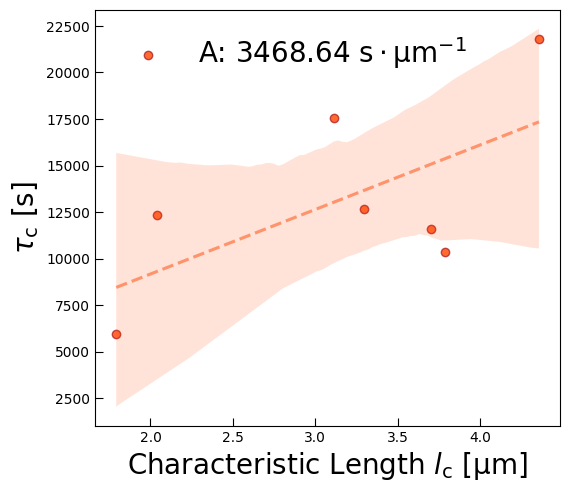

In [ ]:
results = linregress(x = initial_sizes, y = np.array(taus)*60)
print(results)

# Set up plot
plt.figure(figsize = (6, 5.4))
# convert taus from minutes to seconds: multiply by 60
# initial_sizes are already in micron (um)
sns.regplot(
    x = initial_sizes,
    y = np.array(taus)*60,
    color = 'orangered',
    scatter_kws = {'ec' : 'firebrick'},
    line_kws = {'alpha' : 0.5, 'ls' : 'dashed'},
    label = 'A: ' + str(round(results.slope, 2)) + r' $\rm s \cdot \mu m^{-1}$'
)
plt.xlabel(
    r'Characteristic Length $l_{\rm c}$ [$\rm \mu$m]',
    fontsize = 20
)
# plt.xticks([2, 4, 6, 8], fontsize = 20)
# plt.xlim([0, 10])

plt.ylabel(
    r'$\tau_{\rm c}$ [s]',
    fontsize = 20
)
# plt.yticks(
#     [0, 2500, 5000, 7500, 10000, 12500],
#     [0, '', 5000, '', 10000, ''],
#     fontsize = 20
# )
# plt.ylim([-500, 12500])
plt.legend(frameon = False, fontsize = 20)
plt.gca().tick_params(direction = 'in', length = 6)

plt.savefig(RESULTS_DIR + 'sintering_analysis.svg')